<a href="https://colab.research.google.com/github/LvJiaaaaY/Stock-Prediction-Project/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn


from pandas_datareader import data as wb
import yfinance as yfin
yfin.pdr_override()

[*********************100%***********************]  1 of 1 completed


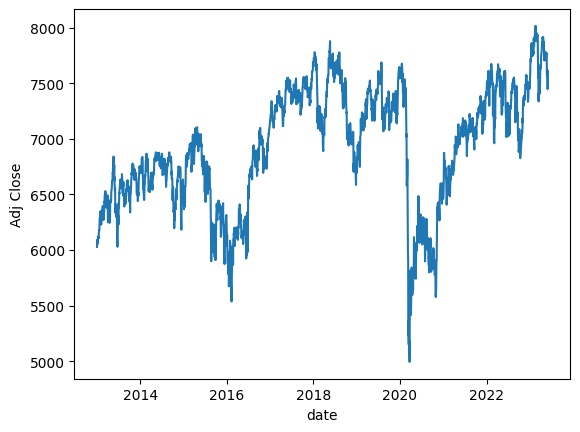

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,5897.799805,6044.600098,5897.799805,6027.399902,6027.399902,652659400
2013-01-03,6027.399902,6051.299805,6016.799805,6047.299805,6047.299805,470665900
2013-01-04,6047.299805,6089.799805,6038.000000,6089.799805,6089.799805,548929200
2013-01-07,6089.799805,6091.500000,6060.799805,6064.600098,6064.600098,571661700
2013-01-08,6064.600098,6088.200195,6053.600098,6053.600098,6053.600098,663115700
...,...,...,...,...,...,...
2023-05-26,7570.899902,7643.600098,7556.899902,7627.200195,7627.200195,817609400
2023-05-30,7627.200195,7628.100098,7516.500000,7522.100098,7522.100098,856682400
2023-05-31,7522.100098,7522.100098,7446.100098,7446.100098,7446.100098,2295618500


In [2]:
# Parameter for data
## Security code
stock_code='^FTSE'
## Start Date
start_date='2013-01-01'
## End Date
end_date='2023-06-03'
## Split ratio of train data and validation data
train_rate=0.8
## How many business days to see
observation_period_num=10
## How many business days to predict
predict_period_num=1

# Parameter for mdoel
## Learning Rate
lr=0.00005
## Epoch Number
epochs=100
## Mini-Batch size
batch_size=64
## How many epochs to stop train if valid loss is not decreasing
patience=20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get data
df=wb.DataReader(stock_code,start=start_date,end=end_date)

# Plot 'Adj Close' values
plt.plot(df.iloc[:,-2])
plt.xlabel('date')
plt.ylabel('Adj Close')
plt.show()

df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                   PLD         AMT        EQIX         PSA     SPG-PJ
Date                                                                 
2023-05-26  124.949997  182.179993  729.150024  286.690002  53.880001
2023-05-30  124.309998  182.000000  734.510010  288.899994  53.700001
2023-05-31  124.550003  184.440002  745.549988  283.299988  54.000000
2023-06-01  122.639999  187.009995  753.260010  283.429993  54.000000
2023-06-02  124.919998  191.149994  757.609985  288.390015  54.049999


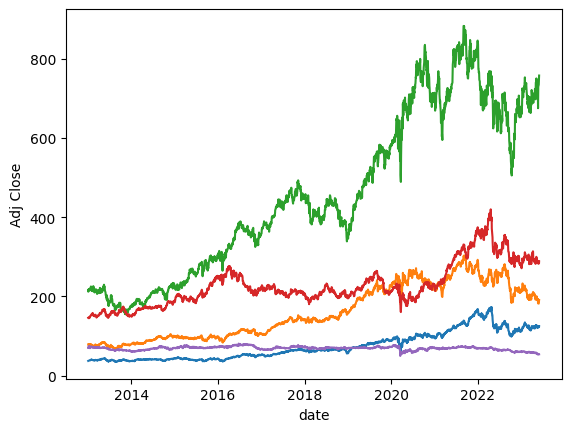

In [3]:
#多个股票同时输入
code_list=['PLD','AMT',"EQIX",'PSA','SPG-PJ']
data_list =[]
for code in code_list:
  data = wb.DataReader(code,start=start_date,end=end_date)['Close'].to_frame()
  data.rename(columns={'Close':code}, inplace = True)
  data_list.append(data)#获取的第二个股票数据接在第一个股票的右边
data = pd.concat(data_list,axis = 1)
print(data.tail())
plt.plot(data)
plt.xlabel('date')
plt.ylabel('Adj Close')
plt.show()

In [4]:
# Normalization
mean_list=df.mean().values
std_list=df.std().values
df=(df-mean_list)/std_list
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,-1.922509,-1.745696,-1.820793,-1.680650,-1.680650,-0.513567
2013-01-03,-1.678833,-1.732926,-1.600127,-1.643220,-1.643220,-1.211452
2013-01-04,-1.641417,-1.659543,-1.560814,-1.563280,-1.563280,-0.911338
2013-01-07,-1.561507,-1.656303,-1.518536,-1.610679,-1.610679,-0.824166
2013-01-08,-1.608888,-1.662592,-1.531886,-1.631369,-1.631369,-0.473470
...,...,...,...,...,...,...
2023-05-26,1.223284,1.302072,1.255744,1.328464,1.328464,0.118962
2023-05-30,1.329141,1.272529,1.180828,1.130778,1.130778,0.268794
2023-05-31,1.131530,1.070488,1.050283,0.987827,0.987827,5.786641


In [5]:
#def calculate_change_pct(data):
  #data['close_pct'] = (data["Close"] - data["Close"].shift(1)) / data["Close"].shift(1)
  #return data
#df = calculate_change_pct(df)
#df
#plt.plot(df.iloc[:,-1])
#plt.xlabel('date')
#plt.ylabel('Change Percentage')
#plt.show()
#df.iloc[:,-1]

In [6]:
# Array initialization
inout_data=[]

# Put data in array
for i in range(len(df)-observation_period_num-predict_period_num):
  data=df.iloc[i:i+observation_period_num,-1].values
  label=df.iloc[i+predict_period_num:i+observation_period_num+predict_period_num,-1].values
  inout_data.append((data,label))
inout_data=torch.FloatTensor(inout_data)[1:]

train_data=inout_data[:int(np.shape(inout_data)[0]*train_rate)].to(device)
valid_data=inout_data[int(np.shape(inout_data)[0]*train_rate):].to(device)

print('train data：',np.shape(train_data)[0])
print('valid data：',np.shape(valid_data)[0])

train data： 2094
valid data： 524


<ipython-input-6-3c52b2fe695e>:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  inout_data=torch.FloatTensor(inout_data)[1:]


In [7]:
# Define a function for getting mini-batch
def get_batch(source, i, batch_size):
  seq_len=min(batch_size, len(source)-1-i)
  data=source[i:i+seq_len]
  input=torch.stack(torch.stack([item[0] for item in data]).chunk(observation_period_num,1))
  target=torch.stack(torch.stack([item[1] for item in data]).chunk(observation_period_num,1))

  return input, target

In [8]:
# Functions for positional encoding
class PositionalEncoding(nn.Module):
  def __init__(self,d_model,max_len=5000):
    super().__init__()
    self.dropout=nn.Dropout(p=0.1)
    pe=torch.zeros(max_len, d_model)
    position=torch.arange(0, max_len,dtype=torch.float).unsqueeze(1)
    div_term=torch.exp(torch.arange(0,d_model, 2).float()*(-math.log(10000.0)/d_model))
    pe[:,0::2]=torch.sin(position*div_term)
    pe[:,1::2]=torch.cos(position*div_term)
    pe=pe.unsqueeze(0).transpose(0,1)
    self.register_buffer("pe",pe)

  def forward(self,x):
    return self.dropout(x+self.pe[:np.shape(x)[0],:])

In [9]:
# Transformer model definition
class TransformerModel(nn.Module):
  def __init__(self,feature_size=250,num_layers=1,dropout=0.1):
    super().__init__()
    self.model_type='Transformer'
    self.src_mask=None
    self.device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    self.pos_encoder=PositionalEncoding(d_model=feature_size)
    self.encoder_layer=nn.TransformerEncoderLayer(d_model=feature_size,nhead=10,dropout=dropout)
    self.transformer_encoder=nn.TransformerEncoder(self.encoder_layer,num_layers=num_layers)
    self.decoder=nn.Linear(feature_size,1)

  def init_weights(self):
    self.decoder.bias.data.zero_()
    self.decoder.weight.data.uniform(-0.1,0.1)

  def _generate_square_subsequent_mask(self,sz):
    mask=(torch.triu(torch.ones(sz,sz))==1).transpose(0,1)
    mask=mask.float().masked_fill(mask==0,float('-inf')).masked_fill(mask==1,float(0.0))
    return mask

  def forward(self,src):
    if self.src_mask is None or self.src_mask.size(0)!=len(src):
      device=self.device
      mask=self._generate_square_subsequent_mask(len(src)).to(device)
      self.src_mask=mask
    src=self.pos_encoder(src)
    output=self.transformer_encoder(src,self.src_mask)
    output=self.decoder(output)
    return output

In [10]:
# Function for early stop of train if valid loss is not decreasing
class EarlyStopping:
    def __init__(self,patience=5):
        self.patience=patience
        self.counter=0
        self.best_score=None
        self.early_stop=False
        self.val_loss_min=np.Inf

    def __call__(self,val_loss,model):
        score=(-val_loss)
        if self.best_score is None:
            self.best_score=score
        elif score==self.patience:
                self.early_stop=True
        else:
            self.best_score=score
            self.counter=0

 10:epoch | 0.01095448 : train loss | 0.9283623 : valid loss
 20:epoch | 0.01047195 : train loss | 0.9272975 : valid loss
 30:epoch | 0.01034618 : train loss | 0.9314336 : valid loss
 40:epoch | 0.01022826 : train loss | 0.9360105 : valid loss
 50:epoch | 0.01015902 : train loss | 0.9398134 : valid loss
 60:epoch | 0.01015034 : train loss | 0.9407457 : valid loss
 70:epoch | 0.01015087 : train loss | 0.9422213 : valid loss
 80:epoch | 0.01011207 : train loss | 0.9429129 : valid loss
 90:epoch | 0.01008511 : train loss | 0.9435724 : valid loss
100:epoch | 0.01013542 : train loss | 0.9436403 : valid loss


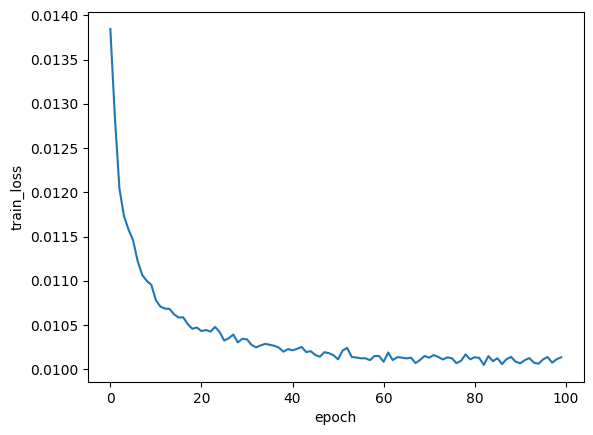

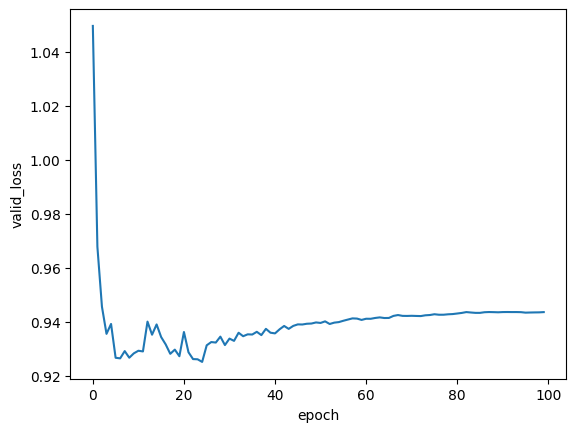

In [11]:
model=TransformerModel().to(device)
criterion=nn.MSELoss()

optimizer=torch.optim.AdamW(model.parameters(),lr=lr)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer,1.0,gamma=0.95)
earlystopping=EarlyStopping(patience)

train_loss_list=[]
valid_loss_list=[]

for epoch in range(1,epochs+1):
  # train
  model.train()
  total_loss_train=0.0
  for batch, i in enumerate(range(0,len(train_data),batch_size)):
    data,targets=get_batch(train_data,i,batch_size)
    optimizer.zero_grad()
    output=model(data)
    loss=criterion(output,targets)
    loss.backward()
    optimizer.step()
    total_loss_train+=loss.item()
  scheduler.step()
  total_loss_train=total_loss_train/len(train_data)

  #valid
  model.eval()
  total_loss_valid=0.0
  for i in range(0,len(valid_data),batch_size):
    data,targets=get_batch(valid_data,i,batch_size)
    output=model(data)
    total_loss_valid+=len(data[0])*criterion(output, targets).cpu().item()
  total_loss_valid=total_loss_valid/len(valid_data)

  #etc
  train_loss_list.append(total_loss_train)
  valid_loss_list.append(total_loss_valid)
  if epoch%10==0:
    print(f'{epoch:3d}:epoch | {total_loss_train:5.7} : train loss | {total_loss_valid:5.7} : valid loss')
  earlystopping((total_loss_valid),model)
  if earlystopping.early_stop:
    print(f'{epoch:3d}:epoch | {total_loss_train:5.7} : train loss | {total_loss_valid:5.7} : valid loss')
    print("Early Stop")
    break

plt.xlabel('epoch')
plt.ylabel('train_loss')
plt.plot(train_loss_list)
plt.show()

plt.xlabel('epoch')
plt.ylabel('valid_loss')
plt.plot(valid_loss_list)
plt.show()

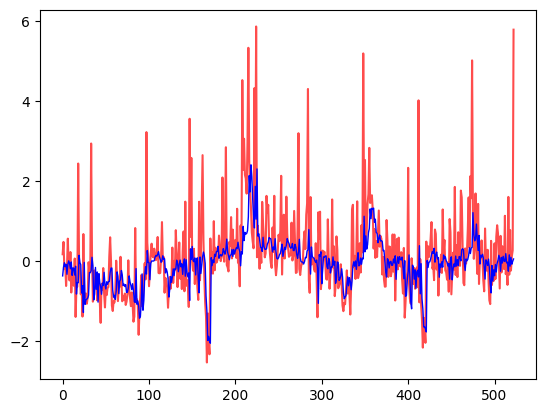

In [12]:
model.eval()
result=torch.Tensor(0)
actual=torch.Tensor(0)

with torch.no_grad():
  for i in range(0,len(valid_data)-1):
    data,target=get_batch(valid_data,i,1)
    output=model(data)
    result=torch.cat((result, output[-1].view(-1).cpu()),0)
    actual=torch.cat((actual,target[-1].view(-1).cpu()),0)

plt.plot(actual,color='red',alpha=0.7)
plt.plot(result,color='blue',linewidth=1.0)
plt.show()